In [1]:
import json
import os
from os import path
from tqdm import tqdm
from tld import get_fld
import numpy as np
import matplotlib.pyplot as plt

In [5]:
DATA_PATH = "/mnt/data/MT/pilot-crawl2"

def isCrawlDataFile(filename: str):
    return filename.endswith(".json") and filename != "metadata.json" and path.isfile(path.join(DATA_PATH, filename))

json_files = [f for f in os.listdir(DATA_PATH) if isCrawlDataFile(f)]
successfully_crawled_sites = len(json_files)
print("Found %d JSON files" % successfully_crawled_sites)

Found 731 JSON files


In [4]:
nr_of_timeouts = 0
saved_calls_sorted_by_type = {}

for filename in tqdm(json_files):
    with open(path.join(DATA_PATH, filename)) as file:
        site_data = json.load(file)
        url = site_data["initialUrl"]
        if site_data["timeout"]:
            nr_of_timeouts += 1

        # Sort saved calls
        ps_data = site_data["data"]["privacySandbox"]
        if not ps_data:
            continue
        saved_calls = ps_data["savedCalls"]
        if len(saved_calls) > 0:
            for saved_call in saved_calls:
                saved_call["initialUrl"] = url # include initialUrl in the saved call data

                call_type = saved_call["description"]
                if call_type not in saved_calls_sorted_by_type:
                    saved_calls_sorted_by_type[call_type] = []

                saved_calls_sorted_by_type[call_type].append(saved_call)

print("Number of timeouts:", nr_of_timeouts)


100%|██████████| 731/731 [00:12<00:00, 60.25it/s]

Number of timeouts: 53


### On which sites are the API calls?

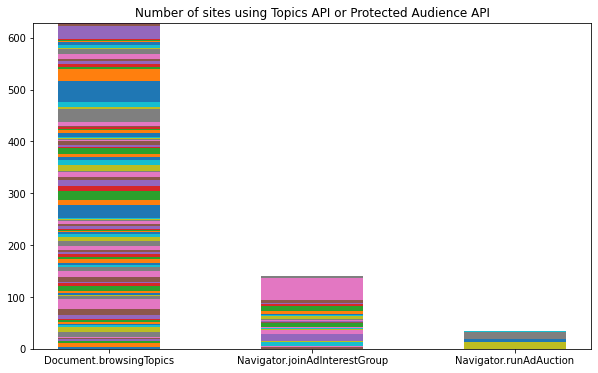

629 calls for Document.browsingTopics, on 98 distinct sites (13.41% of all successfully crawled sites)
	41 uol.com.br
	25 nypost.com
	25 elmundo.es
	24 repubblica.it
	22 usatoday.com
	21 dailymail.co.uk
	18 cnet.com
	13 independent.co.uk
	12 time.com
	12 telegraph.co.uk
	...
141 calls for Navigator.joinAdInterestGroup, on 24 distinct sites (3.28% of all successfully crawled sites)
	42 wiley.com
	12 dell.com
	9 ui.com
	8 netgear.com
	8 rakuten.co.jp
	8 macys.com
	7 scribd.com
	6 ubnt.com
	6 splashtop.com
	4 airbnb.com
	...
34 calls for Navigator.runAdAuction, on 4 distinct sites (0.55% of all successfully crawled sites)
	15 buzzfeed.com
	13 huffpost.com
	5 speedtest.net
	1 chess.com


In [21]:
site_data = {}
types = saved_calls_sorted_by_type.keys()
for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    for call in saved_calls:
        site = get_fld(call["initialUrl"])
        if not site in site_data:
            site_data[site] = np.zeros(len(types))
        site_data[site][i] += 1

width = 0.5

fig, ax = plt.subplots(1, 1, figsize=(10,6))
bottom = np.zeros(3)

for site, nr_of_calls in site_data.items():
    p = ax.bar(types, nr_of_calls, width, label=site, bottom=bottom)
    bottom += nr_of_calls

ax.set_title("Number of sites using Topics API or Protected Audience API")
plt.show()

for i, (call_type, saved_calls) in enumerate(saved_calls_sorted_by_type.items()):
    all_callers = [get_fld(call["initialUrl"]) for call in saved_calls]
    distinct_sites = sorted(set(all_callers), key=lambda d: all_callers.count(d), reverse=True)

    percentage = len(distinct_sites) / successfully_crawled_sites * 100
    print("%d calls for %s, on %d distinct sites (%.2f%% of all successfully crawled sites)"
          % (len(saved_calls), call_type, len(distinct_sites), percentage))
    for site in distinct_sites[:10]:
        print("\t%d %s" % (site_data[site][i], site))
    if len(distinct_sites) > 10:
        print("\t...")

### Which sources are the API calls coming?

In [20]:
for call_type, saved_calls in saved_calls_sorted_by_type.items():
    all_callers = [get_fld(call["source"]) for call in saved_calls]
    distinct_callers = sorted(set(all_callers), key=lambda d: all_callers.count(d), reverse=True)

    print("%d calls for %s, from %d distinct callers" % (len(saved_calls), call_type, len(distinct_callers)))
    for caller in distinct_callers:
        print("\t%d %s" % (all_callers.count(caller), caller))

629 calls for Document.browsingTopics, from 15 distinct callers
	283 doubleclick.net
	113 criteo.com
	68 taboola.com
	54 teads.tv
	39 uol.com.br
	26 weborama.fr
	13 creativecdn.com
	9 top100.ru
	5 pubmatic.com
	5 affec.tv
	4 authorizedvault.com
	4 sunmedia.tv
	3 dailymail.co.uk
	2 walmart.com
	1 fsdn.com
141 calls for Navigator.joinAdInterestGroup, from 2 distinct callers
	102 doubleclick.net
	39 criteo.com
34 calls for Navigator.runAdAuction, from 1 distinct callers
	34 doubleclick.net


### Who are the interest group owners?

In [56]:
all_owners = [call["arguments"]["0"]["owner"] for call in saved_calls_sorted_by_type["Navigator.joinAdInterestGroup"]]
distinct_owners = sorted(set(all_owners), key=lambda d: all_owners.count(d), reverse=True)
print("%d distinct interest group owners:" % (len(distinct_owners)))
for owner in distinct_owners:
    print("\t%d %s" % (all_owners.count(owner), owner))

4 distinct interest group owners:
	102 https://td.doubleclick.net
	23 https://fledge.us.criteo.com
	8 https://fledge.eu.criteo.com
	8 https://fledge.as.criteo.com


### Who are the auction sellers?

In [61]:
all_sellers = [call["arguments"]["0"]["seller"] for call in saved_calls_sorted_by_type["Navigator.runAdAuction"]]
distinct_sellers = sorted(set(all_sellers), key=lambda d: all_sellers.count(d), reverse=True)
print("%d distinct auction sellers:" % (len(distinct_sellers)))
for seller in distinct_sellers:
    print("\t%d %s" % (all_sellers.count(seller), seller))

1 distinct auction sellers:
	34 https://securepubads.g.doubleclick.net
